 
 #  **Project Name:** Efficient Framework Architecture for Dense-Captioning Events in Video using Effective Multi-modal Features Extractor and Event Proposals Generator.

 **Student Name:** Muaad Hammuda Siala

 **Student ID:** 6664948

 **Student Email:** ms02719@surrey.ac.uk

 **Supervisor Name:** Dr Yunpeng Li
 
 **Supervisor Email:** yunpeng.li@surrey.ac.uk


# Notebook Content:
1.   Introduction: 
      - 1.1 Problem.

2.   Framework Components:
      - 2.1 Features Extraction.
      - 2.2 Event Proposals Generation.
      - 2.3 Caption Module. 

3.   Setting up the enviroemnt:
      - 3.1   Installing Python 3.6
      - 3.2   Installing CUDA 10.0
      - 3.3   Installing Torch & Torchvision

4.   Prerequisites:
      - 4.1 Cloning TSRM_HRNN_CMG submodules.
      - 4.2 Download and uncompress the ActivityNet video features and moving them to current Environement.
      - 4.3 Download annotation files and pre-generated (DBG) proposals files from Google Drive. 
      - 4.4 Download Youcook2 dataset. 
      - 4.5 Extracting Youcook dataset.
      - 4.6 Move dataset to current environment. 

5.   Captions Pre-processing:
      - 5.1 Make a dataset of all the sentence flattened with the video names.
      - 5.2 Translate the data using google sheets.
      - 5.3 Removing Arabic Diacritic. 
      - 5.4 Reformat the data to the orignal format. 
      - 5.5 Saving dataset into Train_Modified.json.
      - 5.6 Build vocabulary file.

6. Training:
      - 6.1 Training the model with Cross-entropy loss.
      - 6.2 Evaluation with ground-truth proposals (4917 vid).
      - 6.3 Evaluation with learnt proposals (4917 vid).
      - 6.4 Train the model with reinforcement learning on enlarged training set. 
      - 6.5 Evaluation with ground-truth proposals (1000 vid).
      - 6.6 Evaluation with learnt proposals (1000 vid).




Please, refer to (1) and (2) if you are going to use this notebook in public project. 





# 1. Introduction:

1.1 Dense-captioning Events in Video Problem: 



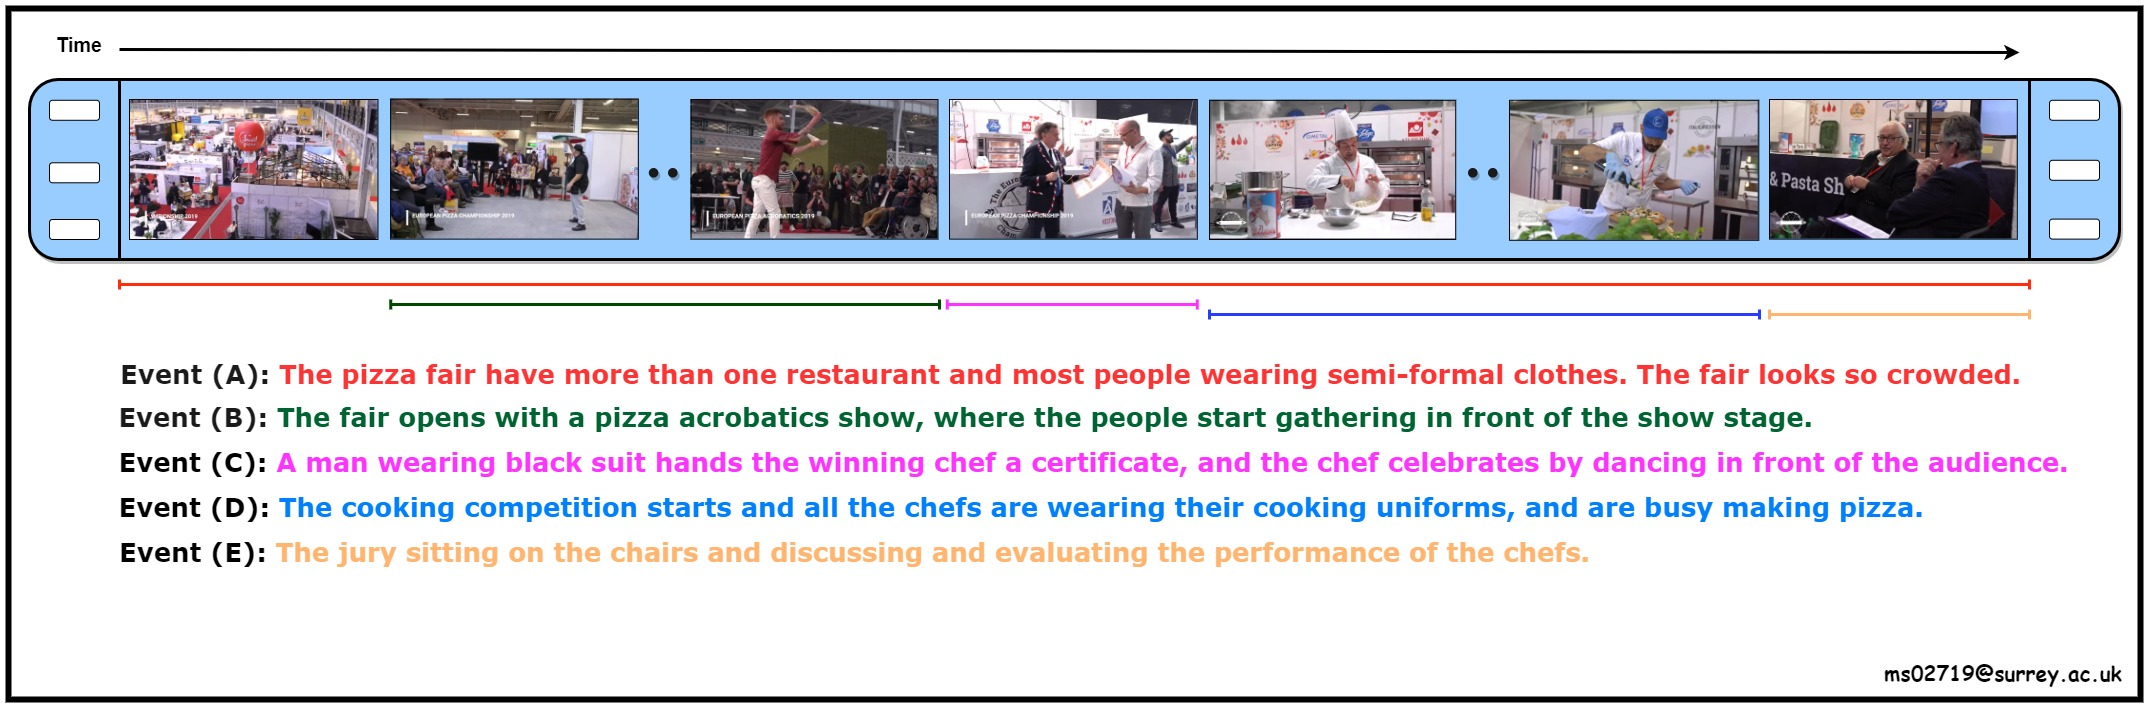

Unlike typical video captioning, where only one sentence is given to describe each short video clip. The dense-captioning events task attempts to create a series of captions to fully describe the events in long video. Dense-captioning events in video requires detecting various events in a video and utilizing natural language to describe each event. Regardless of the events are temporally localized in the video with distinct start and end times, some of these events may also co-occur and overlap in the time. For instance, in figure 1, some models would produce labels like dancing or cooking pizza. Furthermore, some models would probably focus on the pizza fair have more than one restaurant, and most people wearing semi-formal clothes, and the fair looks so crowded (Event A). The fact that the crowd is mentioned and more information about what the fair is about is given in this caption. However, it fails to acknowledge and adequately describe all the other events in the clip. For example, at some point in the video, a man wearing black suit hands the winning chef a certificate and the chef starts celebrating (Event C); few seconds later, other chefs receive a certificate and the model unable to describe it. 

# 2. Framework Components:

 Framework Architecture: 


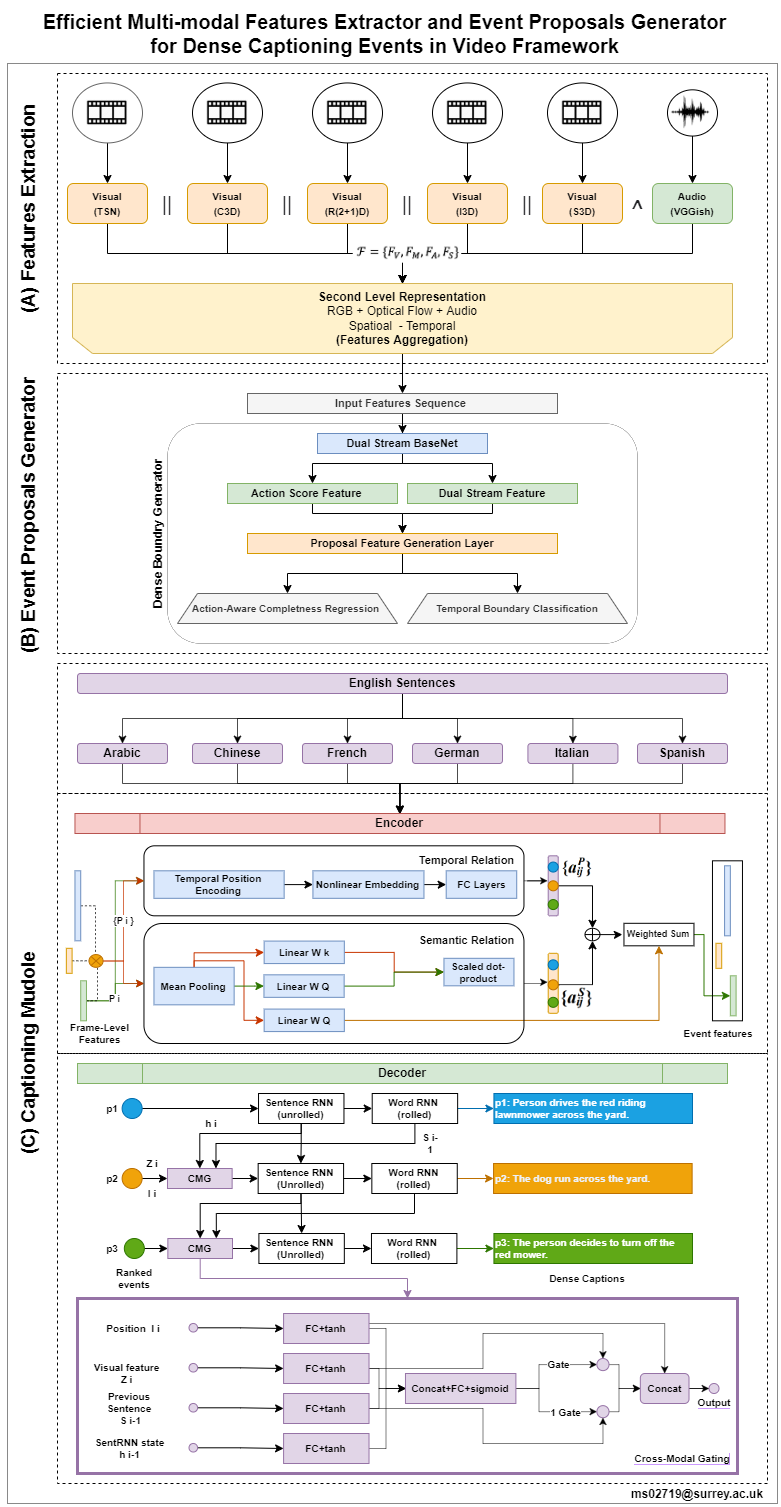

2.1 Features Extraction.
  

In this project, I extracted TSN followed this repo (Link 1:https://github.com/salesforce/densecap): 

Note 1: In order to train the below model, please don't run all the below features cells. Since I train the framework with TSN features, then the following features will be skipped. Simply, skip to section 3.

2.1.1 CLIP Features:


In [ ]:
! git clone https://github.com/v-iashin/video_features.git
! pip install omegaconf==2.0.6 ftfy==6.1.1

Cloning into 'video_features'...
remote: Enumerating objects: 1283, done.
remote: Counting objects: 100% (395/395), done.
remote: Compressing objects: 100% (167/167), done.
remote: Total 1283 (delta 257), reused 306 (delta 212), pack-reused 888
Receiving objects: 100% (1283/1283), 288.54 MiB | 42.31 MiB/s, done.
Resolving deltas: 100% (666/666), done.
Checking out files: 100% (177/177), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 2.0 MB/s 


In [ ]:
%cd video_features

/content/video_features


In [ ]:
from models.clip.extract_clip import ExtractCLIP
from utils.utils import build_cfg_path
from omegaconf import OmegaConf
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
# Select the feature type 
# ('CLIP-ViT-B-32', 'CLIP-ViT-B-16', 'CLIP-RN50x16', 'CLIP-RN50x4','CLIP-RN101', 'CLIP-RN50', 'CLIP-custom')
feature_type = 'clip'
model_name = 'ViT-B/32'

# Load and patch the config
args = OmegaConf.load(build_cfg_path(feature_type))
args.feature_type = feature_type
args.video_paths = ['./sample/v_GGSY1Qvo990.mp4']
args.batch_size = 32
# args.extraction_fps = 1
# args.show_pred = True
# args.pred_texts = ['a dog smiles', 'a woman is lifting']  # if None, does zero-shot on Kinetics 400 classes

# Load the model
extractor = ExtractCLIP(args)

# Extract features
for video_path in args.video_paths:
    print(f'Extracting for {video_path}')
    feature_dict = extractor.extract(video_path)
    [(print(k), print(v.shape), print(v)) for k, v in feature_dict.items()]

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 143MiB/s]
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


Extracting for ./sample/v_GGSY1Qvo990.mp4
clip
(355, 512)
[[-0.04544067  0.25537109  0.34619141 ...  0.15185547 -0.45410156
   0.19287109]
 [-0.0484314   0.25146484  0.34716797 ...  0.16662598 -0.45068359
   0.1932373 ]
 [-0.04641724  0.25439453  0.34790039 ...  0.16809082 -0.44970703
   0.19189453]
 ...
 [-0.30615234  0.25024414 -0.05670166 ...  0.61474609 -0.44995117
   0.15991211]
 [-0.42602539  0.23181152  0.12658691 ...  0.49780273 -0.48925781
   0.09460449]
 [-0.42675781  0.16503906  0.17211914 ...  0.45214844 -0.4206543
   0.10662842]]
fps
()
19.62
timestamps_ms
(355,)
[    0.            50.96839959   101.93679918   152.90519878
   203.87359837   254.84199796   305.81039755   356.77879715
   407.74719674   458.71559633   509.68399592   560.65239551
   611.62079511   662.5891947    713.55759429   764.52599388
   815.49439348   866.46279307   917.43119266   968.39959225
  1019.36799185  1070.33639144  1121.30479103  1172.27319062
  1223.24159021  1274.20998981  1325.1783894   1376

2.1.2 S3D Features:


In [ ]:
! git clone https://github.com/v-iashin/video_features.git
! pip install omegaconf==2.0.6 av==8.0.2

In [ ]:
%cd video_features

In [ ]:
from models.s3d.extract_s3d import ExtractS3D
from utils.utils import build_cfg_path
from omegaconf import OmegaConf
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.get_device_name(0)

In [ ]:
# Select the feature type
feature_type = 's3d'

# Load and patch the config
args = OmegaConf.load(build_cfg_path(feature_type))
args.video_paths = ['./sample/v_GGSY1Qvo990.mp4']
# args.show_pred = True
# args.stack_size = 24
# args.step_size = 24

# Load the model
extractor = ExtractS3D(args)

# Extract features
for video_path in args.video_paths:
    print(f'Extracting for {video_path}')
    feature_dict = extractor.extract(video_path)
    [(print(k), print(v.shape), print(v)) for k, v in feature_dict.items()]

2.1.3 I3D Features:


In [ ]:
! git clone https://github.com/v-iashin/video_features.git
! pip install omegaconf==2.0.6

In [ ]:
%cd video_features

In [ ]:
from models.i3d.extract_i3d import ExtractI3D
from utils.utils import build_cfg_path
from omegaconf import OmegaConf
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.get_device_name(0)

In [ ]:
# Select the feature type
feature_type = 'i3d'

# Load and patch the config
args = OmegaConf.load(build_cfg_path(feature_type))
args.video_paths = ['./sample/v_GGSY1Qvo990.mp4']
# args.show_pred = True
# args.stack_size = 24
# args.step_size = 24
# args.extraction_fps = 25
args.flow_type = 'raft' # 'pwc' is not supported on Google Colab (cupy version mismatch)
# args.streams = 'flow'

# Load the model
extractor = ExtractI3D(args)

# Extract features
for video_path in args.video_paths:
    print(f'Extracting for {video_path}')
    feature_dict = extractor.extract(video_path)
    [(print(k), print(v.shape), print(v)) for k, v in feature_dict.items()]

2.1.4 R(2+1)D Features:


In [ ]:
! git clone https://github.com/v-iashin/video_features.git
! pip install omegaconf==2.0.6 av==8.0.2

In [ ]:
%cd video_features

In [ ]:
from models.r21d.extract_r21d import ExtractR21D
from utils.utils import build_cfg_path
from omegaconf import OmegaConf
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.get_device_name(0)

In [ ]:
# Select the feature type
feature_type = 'r21d'

# Load and patch the config
args = OmegaConf.load(build_cfg_path(feature_type))
args.video_paths = ['./sample/v_GGSY1Qvo990.mp4']
args.model_name = 'r2plus1d_18_16_kinetics'  # default - Acc@1: 57.50, Acc@5: 78.81
# args.model_name = 'r2plus1d_34_32_ig65m_ft_kinetics'  # Acc@1: 79.1, Acc@5: 93.9
# args.model_name = 'r2plus1d_34_8_ig65m_ft_kinetics'
# args.show_pred = True
# args.stack_size = 24
# args.step_size = 24

# Load the model
extractor = ExtractR21D(args)

# Extract features
for video_path in args.video_paths:
    print(f'Extracting for {video_path}')
    feature_dict = extractor.extract(video_path)
    [(print(k), print(v.shape), print(v)) for k, v in feature_dict.items()]

2.1.6 VGGish features

In [ ]:
! git clone https://github.com/v-iashin/video_features.git
! pip install omegaconf==2.0.6

In [ ]:
%cd video_features

In [ ]:
from models.vggish.extract_vggish import ExtractVGGish
from utils.utils import build_cfg_path
from omegaconf import OmegaConf
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.get_device_name(0)

In [ ]:
# Select the feature type
feature_type = 'vggish'

# Load and patch the config
args = OmegaConf.load(build_cfg_path(feature_type))
args.video_paths = ['./sample/v_GGSY1Qvo990.mp4']

# Load the model
extractor = ExtractVGGish(args)

# Extract features
for video_path in args.video_paths:
    print(f'Extracting for {video_path}')
    feature_dict = extractor.extract(video_path)
    [(print(k), print(v.shape), print(v)) for k, v in feature_dict.items()]

2.2 Event Proposals Generation.


In this project I used DBG as event proposlas generation from this (Link 2: https://github.com/Tencent/ActionDetection-DBG)

2.3 Caption Module. 

In this project I used the caption module pretty similar to (Link 3: https://github.com/ttengwang/dense-video-captioning-pytorch). 

#3. Setting up the enviroemnt:

**Note:** the project must run with the following versions:

*   Python version 3.6.9
*   CUDA 10.0
*   Torch 1.12.1 + cu113
*   Torchvision = 0.4
*   The project was conducted on google collab pro (GPU + High Ram).
*   The disk space required for downloading the dataset + saving the models are around 200 GB.
*  The annotation and feature for ActivityNet, and for each split are  (train [27.7 GB], validation [13.7 GB], test [13.6 GB]) and should be decompressed and placed under the dataset directory. 
*   The features files for YouCook2, are (train [9.6 GB], val [3.2 GB], test [1.5 GB]). 
*   The average time for using the GPU for each experiment is 12 hours.
*   The CPU has been tested once with one experiment but it took ages to train the model, better avoid using it.


3.1 Installing Python 3.6

In [ ]:
!python --version

Python 3.7.14


In [ ]:
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.6 1

In [ ]:
!sudo update-alternatives --config python3

There are 2 choices for the alternative python3 (providing /usr/bin/python3).

  Selection    Path                Priority   Status
------------------------------------------------------------
* 0            /usr/bin/python3.7   2         auto mode
  1            /usr/bin/python3.6   1         manual mode
  2            /usr/bin/python3.7   2         manual mode

Press <enter> to keep the current choice[*], or type selection number: 1
update-alternatives: using /usr/bin/python3.6 to provide /usr/bin/python3 (python3) in manual mode


In [ ]:
!python3 --version

Python 3.6.9



3.2 Installing CUDA 10.0

In [ ]:
# install cuda 10.0
!apt-get update;
!wget https://developer.nvidia.com/compute/cuda/10.0/Prod/local_installers/cuda-repo-ubuntu1604-10-0-local-10.0.130-410.48_1.0-1_amd64 -O cuda-repo-ubuntu1604-10-0-local-10.0.130-410.48_1.0-1_amd64.deb
!dpkg -i cuda-repo-ubuntu1604-10-0-local-10.0.130-410.48_1.0-1_amd64.deb
!apt-key add /var/cuda-repo-10-0-local/7fa2af80.pub
!apt-get update
!apt-get -y install gcc-7 g++-7
!apt-get -y install cuda 

!export PATH=/usr/local/cuda/bin${PATH:+:${PATH}}
!export LD_LIBRARY_PATH=/usr/local/cuda/lib64\${LD_LIBRARY_PATH:+:${LD_LIBRARY_PATH}}

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [913 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:14 

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Jun__8_16:49:14_PDT_2022
Cuda compilation tools, release 11.7, V11.7.99
Build cuda_11.7.r11.7/compiler.31442593_0


3.3 Installing Torch & Torchvision

In [ ]:
!sudo apt-get install python3-pip
!python -m pip install --upgrade pip
# uninstall old pytorch
!pip uninstall torch
# install torch
!pip install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  python-pip-whl python3-asn1crypto python3-cffi-backend python3-crypto
  python3-cryptography python3-idna python3-keyring python3-keyrings.alt
  python3-pkg-resources python3-secretstorage python3-setuptools python3-six
  python3-wheel python3-xdg
Suggested packages:
  python-crypto-doc python-cryptography-doc python3-cryptography-vectors
  gnome-keyring libkf5wallet-bin gir1.2-gnomekeyring-1.0
  python-secretstorage-doc python-setuptools-doc
The following NEW packages will be installed:
  python-pip-whl python3-asn1crypto python3-cffi-backend python3-crypto
  python3-cryptography python3-idna python3-keyring python3-keyrings.alt
  python3-pip python3-pkg-resources python3-secretstorage python3-setup

In [ ]:
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Pytorch version
import torch
torch.__version__

'1.12.1+cu113'

In [ ]:
# auto-reloading
%reload_ext autoreload
%autoreload 2
%matplotlib inline

#4. Prerequisites:

4.1 Cloning TSRM_HRNN_CMG submodules.

In [ ]:
# cloning the repo with submodules
!git clone --recurse-submodules -j8 https://github.com/ttengwang/dense-video-captioning-pytorch.git

Cloning into 'dense-video-captioning-pytorch'...
remote: Enumerating objects: 204, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 204 (delta 2), reused 4 (delta 2), pack-reused 196
Receiving objects: 100% (204/204), 137.71 KiB | 8.10 MiB/s, done.
Resolving deltas: 100% (124/124), done.
Submodule 'densevid_eval3/coco-caption' (https://github.com/ttengwang/coco-caption.git) registered for path 'densevid_eval3/coco-caption'
Cloning into '/content/dense-video-captioning-pytorch/densevid_eval3/coco-caption'...
remote: Enumerating objects: 35, done.        
remote: Counting objects: 100% (3/3), done.        
remote: Compressing objects: 100% (3/3), done.        
remote: Total 35 (delta 0), reused 1 (delta 0), pack-reused 32        
Submodule path 'densevid_eval3/coco-caption': checked out '482a57152aa07217197906982d6c62582c0eb9c8'


4.2 Download and uncompress the ActivityNet video features and moving them to current Environement.

In [ ]:
# download and uncompress the ActivityNet video features and moving them to 
!wget http://youcook2.eecs.umich.edu/static/dat/anet_densecap/anet.tar.gz
!tar -xf anet.tar.gz
!cp -a /content/anet/. /content/dense-video-captioning-pytorch/data/resnet_bn

--2022-09-30 20:51:28--  http://youcook2.eecs.umich.edu/static/dat/anet_densecap/anet.tar.gz
Resolving youcook2.eecs.umich.edu (youcook2.eecs.umich.edu)... 141.212.115.67
Connecting to youcook2.eecs.umich.edu (youcook2.eecs.umich.edu)|141.212.115.67|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3562814 (3.4M) [application/octet-stream]
Saving to: ‘anet.tar.gz’

anet.tar.gz         100%[===================>]   3.40M  9.37MB/s    in 0.4s    

2022-09-30 20:51:29 (9.37 MB/s) - ‘anet.tar.gz’ saved [3562814/3562814]




4.3 Download annotation files and pre-generated proposals files from Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls

In [ ]:
# copying the files to the correct location
!cp -a /content/drive/MyDrive/dense-video-captioning-pytorch/. /content/dense-video-captioning-pytorch/data/

In [ ]:
# changing current directory of the notebook
%cd dense-video-captioning-pytorch/

/content/dense-video-captioning-pytorch


In [ ]:
# installing requirements
!pip install -r requirement.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


4.4 Download Youcook2 dataset.

In [ ]:
# download data
!wget http://youcook2.eecs.umich.edu/static/dat/anet_densecap/training_feat_anet.tar.gz
!wget http://youcook2.eecs.umich.edu/static/dat/anet_densecap/validation_feat_anet.tar.gz
!wget http://youcook2.eecs.umich.edu/static/dat/anet_densecap/testing_feat_anet.tar.gz

--2022-09-30 21:11:01--  http://youcook2.eecs.umich.edu/static/dat/anet_densecap/training_feat_anet.tar.gz
Resolving youcook2.eecs.umich.edu (youcook2.eecs.umich.edu)... 141.212.115.67
Connecting to youcook2.eecs.umich.edu (youcook2.eecs.umich.edu)|141.212.115.67|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27679788465 (26G) [application/octet-stream]
Saving to: ‘training_feat_anet.tar.gz’

training_feat_anet. 100%[===================>]  25.78G  56.2MB/s    in 7m 45s  

2022-09-30 21:18:47 (56.8 MB/s) - ‘training_feat_anet.tar.gz’ saved [27679788465/27679788465]

--2022-09-30 21:18:47--  http://youcook2.eecs.umich.edu/static/dat/anet_densecap/validation_feat_anet.tar.gz
Resolving youcook2.eecs.umich.edu (youcook2.eecs.umich.edu)... 141.212.115.67
Connecting to youcook2.eecs.umich.edu (youcook2.eecs.umich.edu)|141.212.115.67|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13731075651 (13G) [application/octet-stream]
Saving to: ‘valida

4.5 Extracting Youcook dataset.

In [ ]:
# Extracting the training features and then remove the zip file to offer more disk space  
!tar xzf /content/dense-video-captioning-pytorch/training_feat_anet.tar.gz -C /content/dense-video-captioning-pytorch/data/resnet_bn/
!rm /content/dense-video-captioning-pytorch/training_feat_anet.tar.gz

In [ ]:
# Extracting the validation features and then remove the zip file to offer more disk space  
!tar xzf /content/dense-video-captioning-pytorch/validation_feat_anet.tar.gz -C /content/dense-video-captioning-pytorch/data/resnet_bn/
!rm /content/dense-video-captioning-pytorch/validation_feat_anet.tar.gz

In [ ]:
# Extracting the testing features and then remove the zip file to offer more disk space  
!tar xzf /content/dense-video-captioning-pytorch/testing_feat_anet.tar.gz -C /content/dense-video-captioning-pytorch/data/resnet_bn/
!rm /content/dense-video-captioning-pytorch/testing_feat_anet.tar.gz

4.6 Move dataset to current environment.

In [ ]:
# Move all files to resnet_bn folder in the current enviroment
!mv /content/dense-video-captioning-pytorch/data/resnet_bn/training/* /content/dense-video-captioning-pytorch/data/resnet_bn/
!mv /content/dense-video-captioning-pytorch/data/resnet_bn/validation/* /content/dense-video-captioning-pytorch/data/resnet_bn/

# 5. Captions Pre-processing:

Note 2: For training the model with english captions. Please skip this section (Only run the cell for building vocabulary which is point 5.7).

5.1 Get the original file.

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_json('/content/dense-video-captioning-pytorch/data/captiondata/train_modified.json').T
df.head(2)

,duration,timestamps,sentences
v_QOlSCBRmfWY,82.73,"[[0.8300000000000001, 19.86], [17.37, 60.81], ...",[A young woman is seen standing in a room and ...
v_ehGHCYKzyZ8,61.72,"[[0, 2.7800000000000002], [3.09, 61.72], [15.4...","[The video starts with a title logo sequence.,..."


In [ ]:
names = []
sentences = []
i = 0
for i in range(len(df)):
    sents = df.iloc[i, 2]
    name = df.index[i]
    for sent in sents:
        sentences.append(sent)
        names.append(name)
assert len(names) == len(sentences), "Number of sentences don't equal number of names"
print(f"Number of sentences: {len(sentences)}")

Number of sentences: 37421


5.1 Make a dataset of all the sentence flattened with the video names.


In [ ]:
new_df = pd.DataFrame({"names":names, "sentences":sentences})
new_df.head()

,names,sentences
0,v_QOlSCBRmfWY,A young woman is seen standing in a room and l...
1,v_QOlSCBRmfWY,The girl dances around the room while the cam...
2,v_QOlSCBRmfWY,She continues dancing around the room and end...
3,v_ehGHCYKzyZ8,The video starts with a title logo sequence.
4,v_ehGHCYKzyZ8,A man and woman are in a living room demonstr...


In [ ]:
new_df.to_excel('sentences.xlsx', index=None)

In [ ]:
# save the dataframe in excel format
new_df = pd.read_excel('sentences.xlsx')
new_df.head(2)

,names,sentences
0,v_QOlSCBRmfWY,A young woman is seen standing in a room and l...
1,v_QOlSCBRmfWY,The girl dances around the room while the cam...


5.2 Translate the dataset using google sheets

In [ ]:
# I copped the file manually in this step!
#!cp -a /content/drive/MyDrive/language/. /content/dense-video-captioning-pytorch/data/


In [ ]:
# Trasnlate and put the files on the cloud and read then again. 

# 1) take the arabic translated copy from the google drive.
# copying the files to the correct location

#/content/drive/MyDrive/dense-video-captioning-pytorch/
#!cp -a /content/drive/MyDrive/language/. /content/dense-video-captioning-pytorch/data/

# copying the files to the correct location


5.3 Load the new (Translated file).


In [ ]:
ar_df = pd.read_excel('/content/dense-video-captioning-pytorch/data/Arabic-Sentences.xlsx')
ar_df.tail(10)

,duration,timestamps,sentences,arabic translation
9999,46.46,"[[0, 13.01], [13.24, 17.66], [17.89, 46.46]]",['A man with a pony tail is seen walking along...,"[""رجل ذو ذيل مهر ينظر إليه وهو يسير على طول حب..."
10000,118.10,"[[0, 10.63], [11.22, 18.9], [18.9, 87.98], [89...",['A man talks to the camera while holding a le...,"[""رجل يتحدث إلى الكاميرا بينما يمسك نوعًا من ا..."
10001,169.46,"[[0, 9.32], [10.17, 15.25], [22.03, 25.42], [2...","['A woman is showing her fingernails.', ' A bo...","[""امرأة تظهر أظافرها."" ، ""يتم عرض زجاجة من الأ..."
10002,224.33,"[[0, 1.12], [1.12, 4.49], [4.49, 223.21], [159...","['We see a lady holding a flute.', ' We see th...","[""نرى سيدة تحمل الفلوت."" ، ""نرى عنوان الأغنية""..."
10003,144.75,"[[2.9, 96.26], [25.33, 54.28], [92.64, 139.69]...",['Teens drive electric bumper cars in an oval ...,""" تخرج السيارة ويصبح الآخرون أحرارًا لمواصلة ا..."
10004,140.23,"[[0, 6.31], [7.01, 129.01], [61, 67.31], [68.0...","['The credits of the clip are shown.', ' Instr...","[""يتم عرض أرصدة المقطع."" ، يتم تقديم تعليمات ح..."
10005,10.50,"[[0, 10.5], [0, 0.68], [0.68, 8.19], [8.24, 10...","['There are two boys playing rock, paper, scis...","[""يوجد صبيان يلعبان موسيقى الروك ، الورق ، مقص..."
10006,105.49,"[[0, 17.41], [17.41, 63.29], [62.77, 105.49]]",['A bald man is standing in an industrial buil...,"[""رجل أصلع يقف في مبنى صناعي مع الكثير من الزج..."
10007,212.12,"[[0, 31.82], [31.82, 78.48], [81.66, 202.57], ...",['People surf in the ocean and a man pass unde...,""" في موجة عالية. ""،"" يسبح الناس في الشاطئ ""."
10008,174.57,"[[0, 46.26], [46.26, 71.57], [72.45, 106.49], ...","['People gather in a restaurant, then a cooker...","[""يتجمع الناس في مطعم ، ثم يظهر طباخ المعكرونة..."


In [ ]:
ar_df.columns

Index(['duration', 'timestamps', 'sentences', 'arabic translation'], dtype='object')

In [ ]:
# rename last column
ar_df = ar_df.rename(columns={'Unnamed: 3': "no_diacritics"})

5.4 Removing Arabic Diacritic.


In [ ]:
!pip install  -q pyarabic

In [ ]:
from pyarabic.stack import Stack

In [ ]:
import pyarabic.araby as araby

In [ ]:
before_filter="اللَّهمَّ اغْفِرْ لنَا ولوالدِينَا"
after_filter = araby.strip_diacritics(before_filter)

print(after_filter)

اللهم اغفر لنا ولوالدينا


In [ ]:
ar_df.head(1)

,duration,timestamps,sentences,arabic translation
0,82.73,"[[0.8300000000000001, 19.86], [17.37, 60.81], ...",['A young woman is seen standing in a room and...,"[""تُرى امرأة شابة وهي تقف في غرفة وتؤدي إلى رق..."


In [ ]:
from tqdm import tqdm

In [ ]:
sents_without_diacritics = []
for sent in tqdm(ar_df['arabic translation'].values):
    sents_without_diacritics.append(araby.strip_diacritics(sent))

100%|██████████| 10009/10009 [00:00<00:00, 88689.81it/s]


In [ ]:
sents_without_diacritics[0]

'["ترى امرأة شابة وهي تقف في غرفة وتؤدي إلى رقصها." ، ترقص الفتاة حول الغرفة بينما تلتقط الكاميرا تحركاتها ". تواصل الرقص حول الغرفة وتنتهي بالاستلقاء على الأرض. \']'

In [ ]:
ar_df['no_diacritics'] = sents_without_diacritics

In [ ]:
ar_df.head()

,duration,timestamps,sentences,arabic translation,no_diacritics
0,82.73,"[[0.8300000000000001, 19.86], [17.37, 60.81], ...",['A young woman is seen standing in a room and...,"[""تُرى امرأة شابة وهي تقف في غرفة وتؤدي إلى رق...","[""ترى امرأة شابة وهي تقف في غرفة وتؤدي إلى رقص..."
1,61.72,"[[0, 2.7800000000000002], [3.09, 61.72], [15.4...",['The video starts with a title logo sequence....,"[""يبدأ الفيديو بتسلسل شعار العنوان."" ، ""رجل وا...","[""يبدأ الفيديو بتسلسل شعار العنوان."" ، ""رجل وا..."
2,31.65,"[[0, 15.51], [11.39, 31.65]]",['Two people are seen moving around a kitchen ...,"[""شوهد شخصان يتنقلان حول المطبخ يقومان بسرعة ب...","[""شوهد شخصان يتنقلان حول المطبخ يقومان بسرعة ب..."
3,36.55,"[[0, 7.49], [7.49, 18.09], [19.37, 36.55]]","['We see a hallway with a wooden floor.', ' A ...","[""نرى ممرًا مع أرضية خشبية."" ، ""كلب في الجوارب...","[""نرى ممرا مع أرضية خشبية."" ، ""كلب في الجوارب ..."
4,145.56,"[[0, 145.56], [67.68, 72.78], [82.97, 87.33], ...",['A woman and a man are sitting on the sidewal...,"[""امرأة ورجل يجلسون على الرصيف يعزفون الموسيقى...","[""امرأة ورجل يجلسون على الرصيف يعزفون الموسيقى..."


5.5 Reformat the data to the orignal format.


In [ ]:
names = []
lists = []
for name in tqdm(new_df['names'].unique()):
    names.append(name)
    lists.append(ar_df[new_df['names'] == name]['no_diacritics'].tolist())

  0%|          | 0/10009 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
100%|██████████| 10009/10009 [00:30<00:00, 331.71it/s]


In [ ]:
len(names), len(lists), 

(10009, 10009)

In [ ]:
new_df = pd.DataFrame({'names':names, 'lists':lists})
new_df.head()

,names,lists
0,v_QOlSCBRmfWY,"[[""ترى امرأة شابة وهي تقف في غرفة وتؤدي إلى رق..."
1,v_ehGHCYKzyZ8,"[[""نرى ممرا مع أرضية خشبية."" ، ""كلب في الجوارب..."
2,v_nwznKOuZM7w,"[[""خطان من الشباب يسيران جنبا إلى جنب أسفل الط..."
3,v_ogQozSI5V8U,"[[""رجل يرتدي بدلة يجلس خلف مكتب."" ، ""الناس يلع..."
4,v_nHE7u40plD0,"[[""ترى غرفة ألعاب تليها صبي صغير ينزلق إلى الش..."


In [ ]:
new_df.iloc[0, 1][0]

'["ترى امرأة شابة وهي تقف في غرفة وتؤدي إلى رقصها." ، ترقص الفتاة حول الغرفة بينما تلتقط الكاميرا تحركاتها ". تواصل الرقص حول الغرفة وتنتهي بالاستلقاء على الأرض. \']'

In [ ]:
df.iloc[0, -1][0]

'A young woman is seen standing in a room and leads into her dancing.'

In [ ]:
df['names'] = df.index

In [ ]:
df.head(1)

,duration,timestamps,sentences,names
v_QOlSCBRmfWY,82.73,"[[0.8300000000000001, 19.86], [17.37, 60.81], ...",[A young woman is seen standing in a room and ...,v_QOlSCBRmfWY


In [ ]:
final_df = df.merge(right=new_df, left_on='names', right_on='names')
final_df.head(2)

,duration,timestamps,sentences,names,lists
0,82.73,"[[0.8300000000000001, 19.86], [17.37, 60.81], ...",[A young woman is seen standing in a room and ...,v_QOlSCBRmfWY,"[[""ترى امرأة شابة وهي تقف في غرفة وتؤدي إلى رق..."
1,61.72,"[[0, 2.7800000000000002], [3.09, 61.72], [15.4...","[The video starts with a title logo sequence.,...",v_ehGHCYKzyZ8,"[[""نرى ممرا مع أرضية خشبية."" ، ""كلب في الجوارب..."


In [ ]:
final_df.index = final_df['names']
final_df.drop(['sentences', 'names'], axis=1, inplace=True)
final_df = final_df.rename(columns={'lists': 'sentences'})

In [ ]:
final_df.head(2)

,duration,timestamps,sentences
names,,,
v_QOlSCBRmfWY,82.73,"[[0.8300000000000001, 19.86], [17.37, 60.81], ...","[[""ترى امرأة شابة وهي تقف في غرفة وتؤدي إلى رق..."
v_ehGHCYKzyZ8,61.72,"[[0, 2.7800000000000002], [3.09, 61.72], [15.4...","[[""نرى ممرا مع أرضية خشبية."" ، ""كلب في الجوارب..."


5.6 Saving dataset into Train_Modified.json.


In [ ]:
# Save a csv copy as a backup 
final_df.to_csv('final_arabic.csv', index=None)

In [ ]:
# Save to json
final_df.to_json('data/captiondata/ar_train_modified.json', orient='index')

5.7 Build vocabulary file.

In [ ]:
# Build vocabulary file, step 3
!python misc/build_vocab.py

video num of train_modified.json 10009
video num of val_1.json 4917
video num of val_2.json 4885
total word: 948929
number of vocab: 5747
number of bad word: 8134
number of unks: 11927
5747
5747
saving vocabulary file to ./data/vocabulary_activitynet.json



# 6. Training:

6.1 Training the model with Cross-entropy loss.


In [ ]:
# Train the model with cross-entropy loss 
cfg_file_path="/content/dense-video-captioning-pytorch/cfgs/tsrm_cmg_hrnn.yml"
!python train.py --cfg_path {cfg_file_path}

/content/dense-video-captioning-pytorch/opts.py:106: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  options_yaml = yaml.load(handle)
Results folder "./save/tsrm_cmg_hrnn" does not exist, creating folder...
backup evironment completed !
load translator, total_vocab: 5747
load captioning file, 10007 captioning loaded
load translator, total_vocab: 5747
load captioning file, 4915 captioning loaded
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


******************** All args: *************************************************
att_hid_size = 512
basic_ss_prob = 0
batch_size = 1
caption_decoder_type = cmg_hrnn
cfg_path = /content/dense-video-capt

6.2 Train the model with reinforcement learning on enlarged training set.


In [ ]:
# Afterward, train the model with reinforcement learning on enlarged training set
cfg_file_path=cfgs/tsrm_cmg_hrnn_RL_enlarged_trainset.yml
python train.py --cfg_path {cfg_file_path}

6.3 Evaluation with ground-truth proposals (4917 vid).


In [ ]:
# Evaluation with ground-truth proposals (standard val set with 4917 videos)
result_folder=tsrm_cmg_hrnn
python eval.py --eval_folder {result_folder}

6.4 Evaluation with learnt proposals (4917 vid).


In [ ]:
# Evaluation with learnt proposals (standard val set with 4917 videos)
result_folder=tsrm_cmg_hrnn
lnt_tap_json=data/generated_proposals/tsn_dbg_esgn_valset_num4717.json
python eval.py --eval_folder {result_folder} --load_tap_json {lnt_tap_json}

6.5 Evaluation with ground-truth proposals (1000 vid).


In [ ]:
# evaluation with ground-truth proposals (small val set with 1000 videos)
result_folder=tsrm_cmg_hrnn_RL_enlarged_trainset
val_caption_file=data/captiondata/expand_trainset/val_1.json
python eval.py --eval_folder {result_folder} --eval_caption_file {val_caption_file}

6.6 Evaluation with learnt proposals (1000 vid).

In [ ]:
# evaluation with learnt proposals (small val set with 1000 videos)
result_folder=tsrm_cmg_hrnn_RL_enlarged_trainset
lnt_tap_json=data/generated_proposals/tsn_dbg_esgn_valset_num4717.json
python eval.py --eval_folder {result_folder} --eval_caption_file {val_caption_file} --load_tap_json $lnt_tap_json